In [10]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.spatial.distance import cdist
import pandas as pd
import cmasher as cmr
import geopandas as gpd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

In [3]:
df=pd.read_csv("IDD.csv",header=None)
ID=df[(df[0]>="760011-99999")&(df[0]<="780160-13601")] 
ID1=ID[0].str.split(pat="-", expand=True) #Separando 
ID["ID"]=ID1[0].astype(int)

esta=pd.read_fwf("ID.txt",header=None)
p=esta[1]
filtered_df = ID[(ID["ID"]).isin(p)]
filtered_df #Encontrando los datos de las estaciones que ocupamos
lat=filtered_df[2].values
lon=filtered_df[3].values
ele=filtered_df[4].values

#Agregando la elevación al dataframe
esta["elevacion"]=ele
esta["Lat"]=lat
esta["Lon"]=lon
esta["Lugar"]=filtered_df[1].values

/tmp/ipykernel_174342/1060579645.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ID["ID"]=ID1[0].astype(int)


In [4]:
#Generando los pares de coordenada de los puntos de las estaciones
X=np.array([[float(esta['Lon'][0]),float(esta["Lat"][0])]])
for i,ii in enumerate(lat):
    if i==0:
        continue
    else:
        X = np.append(X, [[float(esta["Lon"][i]),float(esta['Lat'][i])]], axis=0)

   OBJECTID    LENGTH              EDO          FUENTE         DESCRIP  \
0         1  6.684022  Baja California  Mosaico Filtro  Linea de costa   
1         2  1.806543  Baja California  Mosaico Filtro  Linea de costa   
2         3  0.437371  Baja California  Mosaico Filtro  Linea de costa   
3         4  2.895806  Baja California  Mosaico Filtro  Linea de costa   
4         5  0.581121  Baja California  Mosaico Filtro  Linea de costa   

                                ImageSourc                   Acquisitio  Cov_  \
0  1154014_2014-03-06_RE1_3A_215709_RAW_MS  2014-03-06T19:27:46.382406Z     0   
1  1154014_2014-03-06_RE1_3A_215709_RAW_MS  2014-03-06T19:27:46.382406Z     1   
2  1154014_2014-03-06_RE1_3A_215709_RAW_MS  2014-03-06T19:27:46.382406Z     2   
3  1154014_2014-03-06_RE1_3A_215709_RAW_MS  2014-03-06T19:27:46.382406Z     3   
4  1154014_2014-03-06_RE1_3A_215709_RAW_MS  2014-03-06T19:27:46.382406Z     4   

   Cov_id                                           geometry  
0    

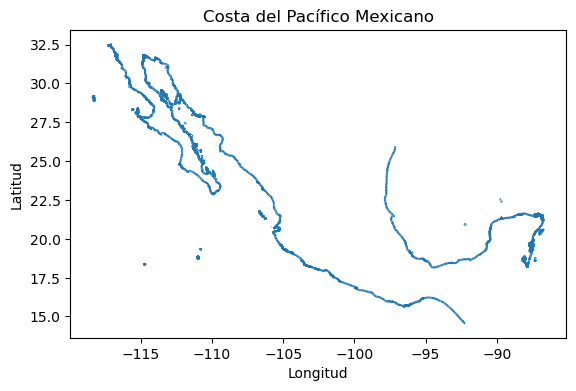

In [5]:
#Cargado datos de la línea costera
costa = gpd.read_file('corte.shp')

# Ver las primeras filas del shapefile
print(costa.head())
# Visualizar la costa
costa.plot()
plt.title('Costa del Pacífico Mexicano')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

In [11]:
#Extrayendo las coordenadas de archivo shape
import shapefile  # pyshp library to read shapefiles

# Carga el archivo shapefile 
shp_path = "corte.shx"
sf = shapefile.Reader(shp_path)

# Extraer todas las geometrías (shapes) del shapefile
shapes = sf.shapes()
coastal_coords = shapes[0].points 
import csv

# Definir la ruta del archivo CSV de salida
csv_path = "coordenadas.csv"

# Extraer y guardar las coordenadas en un CSV
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Longitud", "Latitud"])  # Cabeceras del CSV
    for shape in shapes:
        for point in shape.points:
            writer.writerow(point)  # Escribe cada punto (longitud, latitud)


In [12]:
#Cargando archivo de coordenadas de la costa
coor=pd.read_csv("coordenadas.csv")

In [13]:
#Encontrando la distancia a la costa
from scipy.spatial.distance import cdist
x=coor['Longitud']
y=coor['Latitud']
x_coast = x
y_coast = y  # Curva más compleja

# 3. Calcular distancias a la línea de costa curva
def distance_to_curve(points, x_coast, y_coast):
    # Crear una matriz de puntos de la costa
    coast_points = np.column_stack((x_coast, y_coast))
    # Calcular la distancia desde cada punto a la línea de costa
    distances = cdist(points, coast_points)
    return distances.min(axis=1)  # Tomar la distancia mínima a la costa

# Calcular las distancias
distances = distance_to_curve(X, x, y)

In [14]:
#Cargando los datos con los que se harán los clusters
da_list=[]
for i,ii in enumerate(esta[1]):
    datos=xr.open_dataset(f"/home/andreagvc/data/ERA/ERA/Datos_HAD/{ii}99999_estadisticos.nc")
    datos=datos.assign_coords(estacion=ii)
    datos=datos.expand_dims('estacion')
    da_list.append(datos)
ERA=xr.concat(da_list,dim='estacion')

In [15]:
#Seleccionando la temperatura para hacer el cluster
temp=ERA.Tmean.groupby("time.year").mean("time")
temp1=temp.mean("year")

#Seleccionando los datos de humedad específica
humedad=ERA.SHmean.resample(time="YE").mean()
humedad1=humedad.mean("time")


In [16]:
#Generando un data frame que me guarde las variables para el clustering, para este caso sería la distancia a la costa y el valor de la humedad específica
df2 = pd.DataFrame({
    'distancia_costa': distances,
    'elevacion': esta["elevacion"].astype(float),
    'temperatura':temp1.astype(float),
    'lat':esta["Lat"],
    'Lon':esta["Lon"],
    'humedad':humedad1,
    'localidad':esta["Lugar"],
    "ID":esta[1]
})
df2

,distancia_costa,elevacion,temperatura,lat,Lon,humedad,localidad,ID
0,0.073636,149.0,16.110423,32.541,-116.97,0.007546,GENERAL ABELARDO L RODRIGUEZ,760013
1,0.918990,22.6,24.949962,32.631,-115.242,0.007946,GENERAL RODOLFO SANCHEZ TABOA,760053
2,0.689861,11.0,24.814388,32.4,-115.183,0.010245,EJIDO NUEVO LEON BC.,760400
3,5.556492,1167.0,23.256915,31.633,-106.433,0.006878,CIUDAD INTL,760751
4,5.561466,1189.9,21.177866,31.636,-106.429,0.005907,ABRAHAM GONZALEZ INTL,760753
...,...,...,...,...,...,...,...,...
85,1.050479,576.0,24.669832,16.75,-93.133,0.014432,TUXTLA GUTIERREZ CHIS.,768430
86,1.342305,2116.0,15.404542,16.75,-92.633,0.011363,SN. CRISTOBAL LAS CASAS CHIS,768450
87,1.288937,1646.0,18.364675,16.25,-92.133,0.011331,COMITAN CHIS.,768480
88,0.262532,118.0,27.420407,14.917,-92.25,0.017210,TAPACHULA CHIS,769030


In [17]:
#Realizando el clustering
# Variables a considerar en la clasificación
features = df2[['distancia_costa', 'temperatura',"elevacion"]]

#Escalando los datos
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Aplicar K-means con 2 clústers
kmeans = KMeans(n_clusters=2)
kmeans.fit(scaled_features)

# Agregar las etiquetas de los clusters al DataFrame
df2['cluster'] = kmeans.labels_

centroids = kmeans.cluster_centers_

/home/estudiantes/anaconda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
#Seleccionando los datos para cada cluster
cluster0=df2.loc[df2["cluster"]==0]
cluster1=df2.loc[df2["cluster"]==1]

In [ ]:
#Creando un archivo con la información de la clasificación
df2.to_csv('clustering_Had.csv', index=False) 